In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
from matplotlib import cm
import seaborn as sns
import datetime as dt

In [2]:
df = pd.read_csv("Original_data_converted_to_csv_from_rds_file.csv").drop("Unnamed: 0", axis=1)
df['LoanTenor'] = df.LoanTenor.str.lower()
len(df)

336291

In [3]:
df.columns

Index(['applicationnumber', 'loantype', 'DisbursalDate', 'LoanTenor',
       'LoanAmount', 'SectorDescription', 'EstablishedSinceMonths',
       'CurrentAddressSinceMonths', 'DocumentCharge', 'EMI', 'InterestRate',
       'InsuranceRate', 'InsuranceAmount', 'MariatlStatus', 'AccomodationType',
       'BussinessLegalStatus', 'ResidenceType', 'RentAmount', 'MailThrough',
       'OtherLoanBank', 'NoOfDependents', 'Qualification', 'NetBusinessIncome',
       'NetDisposableIncome', 'ProfessionDesc', '30 DPDs Instance', 'DPD30',
       'DataType'],
      dtype='object')

In [4]:
df['Year'] = pd.DatetimeIndex(df['DisbursalDate']).year
df = df[(df.Year == 2018) | (df.Year == 2017)]
len(df)

64206

In [5]:
df.groupby(['Year']).agg('count').applicationnumber

Year
2017    62372
2018     1834
Name: applicationnumber, dtype: int64

In [6]:
df = df[df.DataType == "New"]
len(df)

43002

In [7]:
df['DisbursalDate'] = pd.to_datetime(df.DisbursalDate)
df['Month_and_Year'] = pd.to_datetime(df['DisbursalDate']).dt.to_period('M')
#----------------------
drop_vars = ['applicationnumber', 'DisbursalDate', 'MariatlStatus', 'AccomodationType', 'BussinessLegalStatus',
             'ResidenceType', 'RentAmount', 'MailThrough','OtherLoanBank']#, '', '', '', '', '', '','','','', ]
df = df.drop(drop_vars, axis=1)
#----------------------
df.SectorDescription[df.SectorDescription == 'OTHERS'] = "Others"
#----------------------
df = df[df.EstablishedSinceMonths < 300]
#----------------------
df = df[df.CurrentAddressSinceMonths < 480]
#----------------------
df = df[df.NoOfDependents < 10]
#----------------------
df = df[(df.NetDisposableIncome >= 0) & (df.NetDisposableIncome < 42000)]
#----------------------
df.ProfessionDesc[(df.ProfessionDesc == "Dairy Products")|
                     (df.ProfessionDesc == "Baker")|
                     (df.ProfessionDesc == "Food & Beverages")] = 'Food'
df.ProfessionDesc[(df.ProfessionDesc == "Shoe Trading")|
                     (df.ProfessionDesc == "Merchant")] = 'Traders'
df.ProfessionDesc[(df.ProfessionDesc == "Surgical")|
                     (df.ProfessionDesc == "Doctor")] = 'Medical'
df.ProfessionDesc[df.ProfessionDesc == "Teacher"] = 'Education'
df.ProfessionDesc[df.ProfessionDesc == "Live Stock"] = 'Maal Mawaishi'
df.ProfessionDesc[df.ProfessionDesc == "Electrical"] = 'Electrician' 
df.ProfessionDesc[df.ProfessionDesc == "Mechanic"] = 'Self Employed' 
df.ProfessionDesc[df.ProfessionDesc.isin(df.ProfessionDesc.value_counts()[10:].index)] = 'Other'
#----------------------
df = df[df.NetBusinessIncome < 42000]
#----------------------
df = df.drop(['30 DPDs Instance', 'DataType'], axis=1)

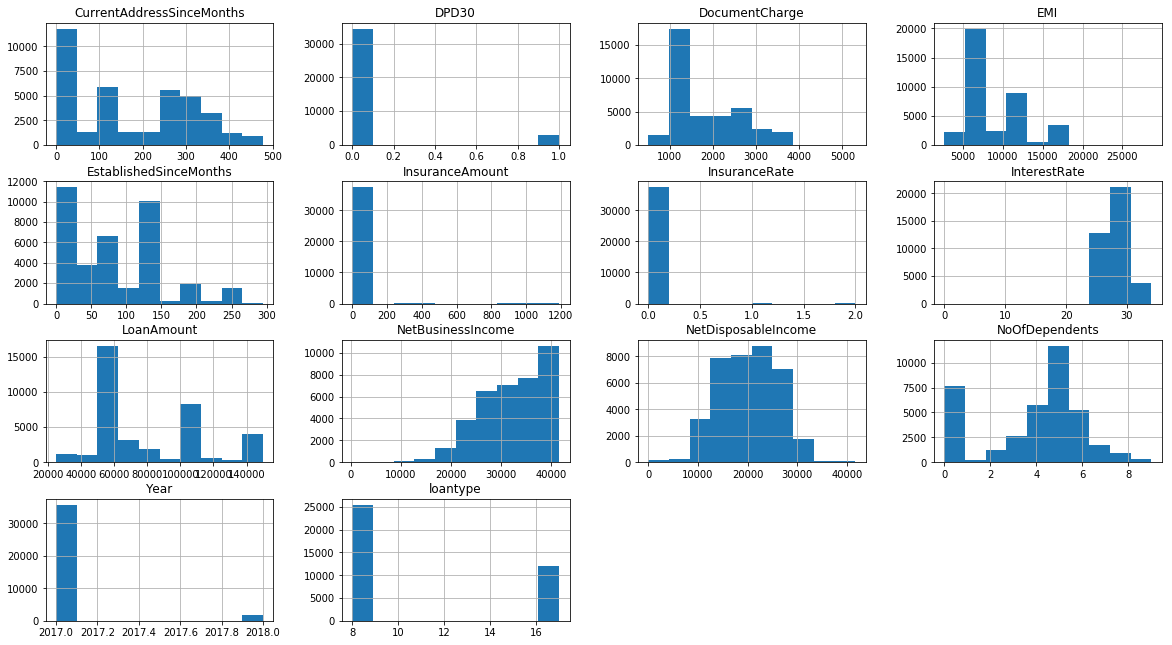

In [14]:
df[df.dtypes[(df.dtypes == 'int64')|
         (df.dtypes == 'float64')].index].hist(figsize=[20,11])
plt.show()

In [15]:
vars_for_dummies = list(df.dtypes[df.dtypes == 'O'].index) + ['loantype', 'Month_and_Year']
df['Month_and_Year'] = df.Month_and_Year.astype("O")
dummy_vars_df = pd.get_dummies(df[vars_for_dummies])
final_df = pd.concat([df, dummy_vars_df], axis=1, ignore_index=True)
final_df.columns = list(df.columns) + list(dummy_vars_df.columns)
final_df = final_df.drop(vars_for_dummies, axis=1)

X_train, X_test, y_train, y_test = train_test_split(final_df.drop('DPD30', axis=1), 
                                                    final_df.DPD30, test_size = 0.25)
print("Train: ", len(X_train))
print("Test: ", len(X_test))

Train:  28084
Test:  9362


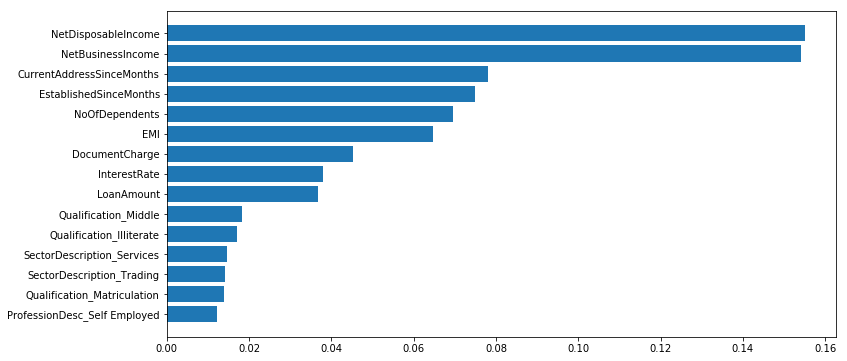

In [50]:
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=80)
rnd_clf.fit(X_train, y_train)

names = []
importanc = []
for name, importance in zip(X_train.columns, rnd_clf.feature_importances_):
    if importance > 0.01:
        names.append(name)
        importanc.append(importance)

df = pd.DataFrame()
for i in ['names', 'importanc']:
    df[i] = eval(i)
df = df.sort_values('importanc')
plt.figure(figsize=(12,6))
plt.barh(df.names, df.importanc)
plt.show()

In [ ]:
tn = []
fp = []
fn = []
tp = []
one_proportion = []
zero_proportion = []
acuracy = []
one_weight = []
zero_weight = []
def rendomforest(i, z):
    X_train, X_test, y_train, y_test = train_test_split(final_df.drop('DPD30', axis=1), 
                                                    final_df.DPD30, test_size = 0.25)
    clf=RandomForestClassifier(n_estimators=100, n_jobs=200, class_weight = {1:i,0:z})
    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    cm = confusion_matrix(y_test, predicted).ravel()
    TN, FP, FN, TP = cm / sum(cm)
    tn.append(TN); fp.append(FP); fn.append(FN); tp.append(TP) 
    acuracy.append(round(np.mean(predicted == y_test), 2))
    one_proportion.append(sum(y_test == 0))
    zero_proportion.append(sum(y_test == 1))

for i in range(1, 40):
    for z in np.linspace(0.001, 40, num=10):
        one_weight.append(i)
        zero_weight.append(z)
        rendomforest(i, z)

In [52]:
p = pd.DataFrame()
for i in ['tn', 'fp', 'fn', 'tp', 'acuracy', 'one_weight', 'zero_weight']:
    p[i] = eval(i)
p['Precision'] = p.tp/(p.tp+p.fp)
p['Recall'] = p.tp / (p.tp + p.fn)
p['one %'] = np.array(one_proportion)/len(X_test)
p['zero %'] = np.array(zero_proportion)/len(X_test)
p.to_csv("statistics_randomForest_on_small_cleaned_data3.csv")

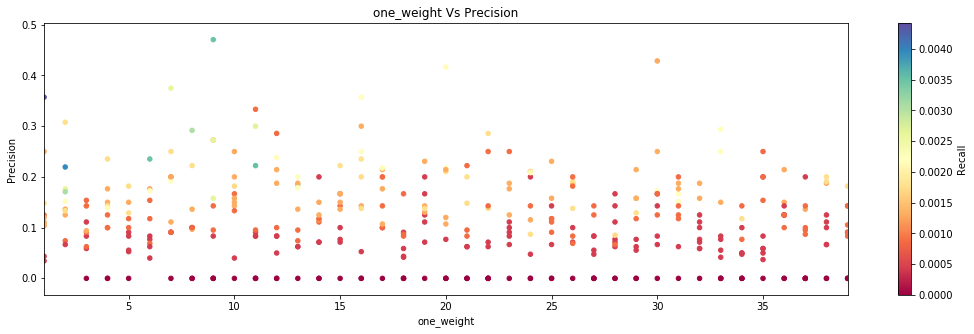

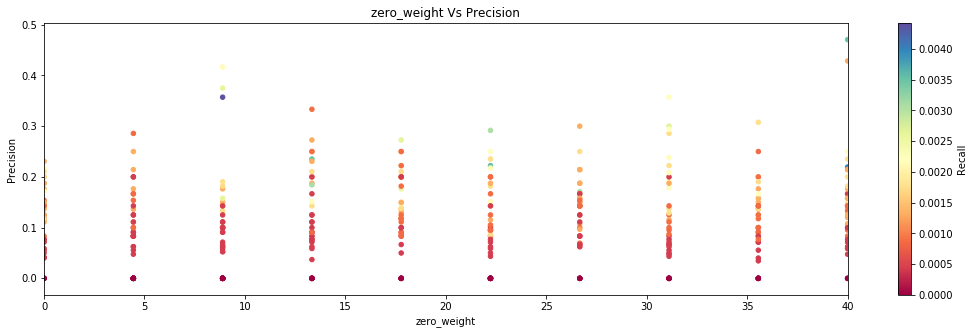

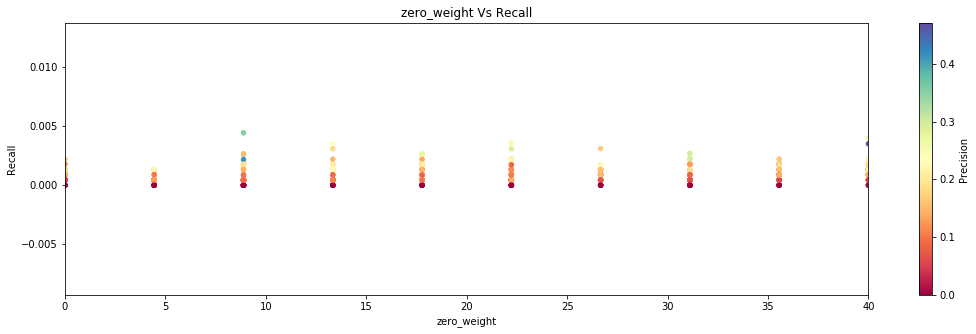

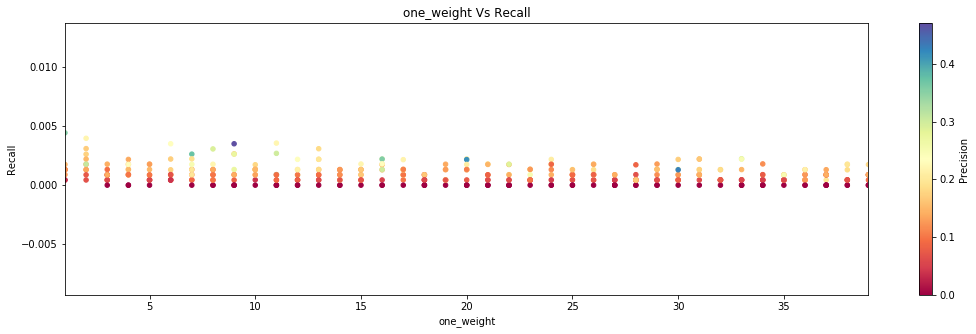

In [53]:
cmap = cm.get_cmap('Spectral')
for i in [('one_weight', 'Precision'), ('zero_weight', 'Precision'), 
          ('zero_weight', 'Recall'), ('one_weight', 'Recall')]:
    fig = plt.figure()
    plt.title(i[0] + " Vs " + i[1])
    plt.ylabel(i[1])
    ax = plt.subplot(111)
    p.plot(i[0], i[1], c = 'Precision' if (i[1]=='Recall') else 'Recall', 
                   figsize=(18, 5), cmap=cmap, ax=ax, kind='scatter')
    ax.set_xlim(p[[i[0]]].min()[i[0]], p[[i[0]]].max()[i[0]])

Text(0.5, 1.0, 'Precision VS Recall')

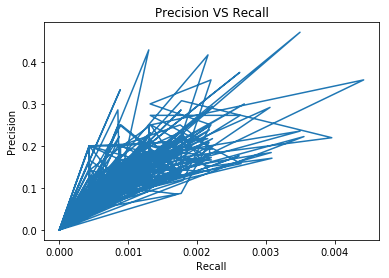

In [54]:
plt.plot(p.Recall, p.Precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision VS Recall")

In [55]:
p.sort_values(["Recall", "Precision"], ascending=False)

tn        fp        fn        tp  acuracy  one_weight  zero_weight  \
2    0.918818  0.000641  0.080185  0.000356     0.92           1     8.889667   
19   0.917892  0.001139  0.080648  0.000320     0.92           2    40.000000   
105  0.918853  0.000997  0.079865  0.000285     0.92          11    22.222667   
53   0.917643  0.000926  0.081147  0.000285     0.92           6    13.334000   
89   0.918213  0.000320  0.081182  0.000285     0.92           9    40.000000   
16   0.918106  0.001211  0.080434  0.000249     0.92           2    26.667000   
123  0.917928  0.001104  0.080719  0.000249     0.92          13    13.334000   
75   0.917963  0.000605  0.081182  0.000249     0.92           8    22.222667   
107  0.919993  0.000498  0.079295  0.000214     0.92          11    31.111333   
82   0.917963  0.001139  0.080684  0.000214     0.92           9     8.889667   
84   0.918106  0.000570  0.081111  0.000214     0.92           9    17.778333   
62   0.918141  0.000356  0.081289  0.000214     0.92           7     8.889667   
14   0.917216  0.000997  0.081574  0.000214     0.92           2    17.778333   
327  0.919637  0.000427  0.079758  0.000178     0.92          33    31.111333   
190  0.919352  0.000641  0.079829  0.000178     0.92          20     0.001000   
67   0.919067  0.000748  0.080007  0.000178     0.92           7    31.111333   
308  0.918533  0.000890  0.080399  0.000178     0.92          31    35.555667   
59   0.918497  0.000855  0.080470  0.000178     0.92           6    40.000000   
157  0.918889  0.000320  0.080612  0.000178     0.92          16    31.111333   
15   0.918177  0.000997  0.080648  0.000178     0.92           2    22.222667   
155  0.918604  0.000534  0.080684  0.000178     0.92          16    22.222667   
303  0.918141  0.000997  0.080684  0.000178     0.92          31    13.334000   
329  0.918462  0.000534  0.080826  0.000178     0.92          33    40.000000   
127  0.917678  0.000819  0.081325  0.000178     0.92          13    31.111333   
117  0.917785  0.000570  0.081467  0.000178     0.92          12    31.111333   
128  0.917643  0.000712  0.081467  0.000178     0.92          13    35.555667   
34   0.917073  0.001104  0.081645  0.000178     0.92           4    17.778333   
237  0.917465  0.000677  0.081681  0.000178     0.92          24    31.111333   
290  0.917216  0.000855  0.081752  0.000178     0.92          30     0.001000   
192  0.917322  0.000249  0.082250  0.000178     0.92          20     8.889667   
..        ...       ...       ...       ...      ...         ...          ...   
255  0.918533  0.000463  0.081004  0.000000     0.92          26    22.222667   
262  0.918497  0.000249  0.081253  0.000000     0.92          27     8.889667   
265  0.918711  0.000356  0.080933  0.000000     0.92          27    22.222667   
266  0.918569  0.000463  0.080968  0.000000     0.92          27    26.667000   
268  0.919423  0.000570  0.080007  0.000000     0.92          27    35.555667   
273  0.919530  0.000534  0.079936  0.000000     0.92          28    13.334000   
274  0.917857  0.000178  0.081965  0.000000     0.92          28    17.778333   
282  0.918213  0.000641  0.081147  0.000000     0.92          29     8.889667   
284  0.918426  0.000712  0.080862  0.000000     0.92          29    17.778333   
297  0.918355  0.000320  0.081325  0.000000     0.92          30    31.111333   
301  0.918213  0.000356  0.081431  0.000000     0.92          31     4.445333   
314  0.919316  0.000570  0.080114  0.000000     0.92          32    17.778333   
322  0.918497  0.000570  0.080933  0.000000     0.92          33     8.889667   
323  0.918640  0.000178  0.081182  0.000000     0.92          33    13.334000   
326  0.918355  0.000748  0.080897  0.000000     0.92          33    26.667000   
333  0.918035  0.000498  0.081467  0.000000     0.92          34    13.334000   
335  0.916895  0.000285  0.082820  0.000000     0.92          34    22.222667   
339  0.917750  0.000107  0.082143  0.00000

In [56]:
from sklearn.preprocessing import StandardScaler
from matplotlib import style
from nltk import FreqDist
style.use('fivethirtyeight')
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
LDA = LinearDiscriminantAnalysis()
LDA.fit(X_train,y_train)
predicted = LDA.predict(X_test)

In [58]:
FreqDist(predicted), FreqDist(y_test)

(FreqDist({0: 9321, 1: 41}), FreqDist({0: 8624, 1: 738}))

In [59]:
cm = confusion_matrix(y_test, predicted).ravel()
TN, FP, FN, TP = cm / sum(cm)
TN, FP, FN, TP 

(0.9176458021790216,
 0.0035248878444776757,
 0.07797479171117283,
 0.0008545182653279214)

In [29]:
from sklearn.cluster import KMeans

In [122]:
X_train, X_test, y_train, y_test = train_test_split(final_df.drop('DPD30', axis=1), 
                                            final_df.DPD30, test_size = 0.25)

def to_clusters(n=5):
#     n = int(input("How many clusters you want?"))
    df = pd.concat([X_train, y_train], axis=1)
    model = KMeans(n_clusters=15, n_init=50)
    model.fit(df[['NetBusinessIncome','NetDisposableIncome', 'DPD30']])
    df['labels'] = model.labels_    
    all_clusturs = []
    for i in df.labels.unique():
        all_clusturs.append(df[df.labels == i])
    
    return all_clusturs

In [112]:
def distribution_within_each_cluster(list_of_clusters):
    size = []
    a_0 = []
    a_1 = []
    df = pd.DataFrame()
    
    for cluster in list_of_clusters:
        cluster_y_distribution = cluster.DPD30.value_counts()
        size.append(len(cluster))
        if 0 in cluster_y_distribution.index:
            a_0.append(cluster_y_distribution.loc[0])
        else:
            a_0.append(0)

        if 1 in cluster_y_distribution.index:
            a_1.append(cluster_y_distribution.loc[1])
        else:
            a_1.append(0)

    for i in ['size', 'a_1', 'a_0']: 
        df[i] = eval(i)
    df.columns = ['size', '1', '0']
    zz = pd.Series({'1' : df['1'].sum(),
                   '0' : df['0'].sum()},
                   name='AVERAGE or SUM')
    
    avg = pd.DataFrame(df.append(zz))
    avg['1%'] = avg['1'] / (avg['1'] + avg['0'])
    avg['0%'] = avg['0'] / (avg['1'] + avg['0'])
    return avg
distribution_within_each_cluster(to_clusters())

size       1        0        1%        0%
0               2558.0   175.0   2383.0  0.068413  0.931587
1               1698.0   150.0   1548.0  0.088339  0.911661
2               2069.0   177.0   1892.0  0.085549  0.914451
3               2676.0   236.0   2440.0  0.088191  0.911809
4               2044.0   169.0   1875.0  0.082681  0.917319
5               2399.0   194.0   2205.0  0.080867  0.919133
6               1981.0   119.0   1862.0  0.060071  0.939929
7               1833.0   157.0   1676.0  0.085652  0.914348
8               2439.0   201.0   2238.0  0.082411  0.917589
9               2351.0   201.0   2150.0  0.085496  0.914504
10              1004.0    72.0    932.0  0.071713  0.928287
11              2897.0   251.0   2646.0  0.086641  0.913359
12              1716.0   146.0   1570.0  0.085082  0.914918
13               119.0    13.0    106.0  0.109244  0.890756
14               300.0    24.0    276.0  0.080000  0.920000
AVERAGE or SUM     NaN  2285.0  25799.0  0.081363  0.918637

In [123]:
# %%time
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from nltk import FreqDist
import pandas as pd
import numpy as np
import os
import pickle 
from nltk import FreqDist
from sklearn.metrics import confusion_matrix

proportion_of_0 = []
proportion_of_1 = []
names = []
Accuracy = []
size = []
frequancy = []
TN = []
FP = []
TP = []
FN = []

for cluster in to_clusters():
    lst = []
    X = cluster.drop(["DPD30", "labels"], axis=1)
    y = cluster.DPD30
    clf=RandomForestClassifier(n_jobs=40)
    clf.fit(X, y)
    predicted = clf.predict(X_test.drop("labels", axis=1))
    cm = confusion_matrix(predicted, y_test).ravel()

    tn, fp, fn, tp = cm / sum(cm)
    TN.append(round(tn, 4))
    FP.append(round(fp, 4))
    FN.append(round(fn, 4))
    TP.append(round(tp, 4))
    size.append(len(cluster))
    Accuracy.append(round(np.mean(predicted == y_test), 4))

    t = cluster.DPD30.value_counts()
    if 1 in t:
        proportion_of_1.append(round(dict(t)[1] / t.sum(), 4))
    else:
        proportion_of_1.append(0)
    if 0 in t:
        proportion_of_0.append(round(dict(t)[0] / t.sum(), 4))
    else:
        proportion_of_0.append(0)

d = pd.DataFrame()
for i in ['size', 'TN', 'FN', 'TP', "FP", "proportion_of_0", "proportion_of_1", "Accuracy"]:
    d[i] = eval(i)
d = d.sort_values(by=['TP', "TN"], ascending=False)
# df.to_csv("results_of_random_forest_for_all_clusters.csv")
d[d.Accuracy > d.proportion_of_0].sort_values("Accuracy", ascending=False)

size      TN      FN      TP      FP  proportion_of_0  proportion_of_1  \
13   441  0.9217  0.0002  0.0001  0.0780           0.9206           0.0794   
14   116  0.9218  0.0001  0.0000  0.0781           0.9138           0.0862   
6   2721  0.9185  0.0034  0.0005  0.0775           0.9111           0.0889   
5   2008  0.9183  0.0036  0.0002  0.0779           0.9124           0.0876   
2   1946  0.9170  0.0049  0.0010  0.0771           0.9096           0.0904   

    Accuracy  
13    0.9218  
14    0.9218  
6     0.9190  
5     0.9185  
2     0.9180

In [124]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

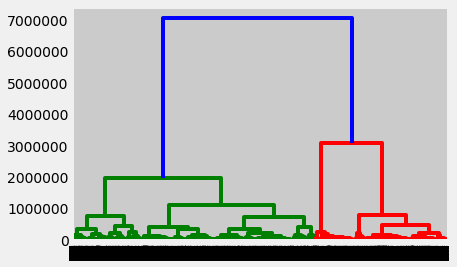

In [154]:
dendrogram = sch.dendrogram(sch.linkage(X_train, method='ward'))

# create clusters
hc = AgglomerativeClustering(n_clusters=12, affinity = 'euclidean', linkage = 'ward')

# save clusters for chart
y_hc = hc.fit_predict(X_train)

In [166]:
proportion_of_0 = []
proportion_of_1 = []
names = []
Accuracy = []
size = []
frequancy = []
TN = []
FP = []
TP = []
FN = []

X_train['labels'] = y_hc
x_y = pd.concat([X_train, y_train], axis=1)
for i in x_y.labels.unique():
    df = x_y[x_y.labels == i]
#     print(i, sum(df.DPD30 == 0)/len(df), sum(df.DPD30 == 1)/len(df))
    clf=RandomForestClassifier(n_jobs=40)
    clf.fit(X_train.drop("labels", axis=1), y_train)
    predicted = clf.predict(X_test.drop("labels", axis=1))
    cm = confusion_matrix(predicted, y_test).ravel()

    tn, fp, fn, tp = cm / sum(cm)
    TN.append(round(tn, 4))
    FP.append(round(fp, 4))
    FN.append(round(fn, 4))
    TP.append(round(tp, 4))
    size.append(len(df))
    Accuracy.append(round(np.mean(predicted == y_test), 4))

    t = cluster.DPD30.value_counts()
    if 1 in t:
        proportion_of_1.append(round(dict(t)[1] / t.sum(), 4))
    else:
        proportion_of_1.append(0)
    if 0 in t:
        proportion_of_0.append(round(dict(t)[0] / t.sum(), 4))
    else:
        proportion_of_0.append(0)

d = pd.DataFrame()
for i in ['size', 'TN', 'FN', 'TP', "FP", "proportion_of_1", "proportion_of_0", "Accuracy"]:
    d[i] = eval(i)
d = d.sort_values(by=['TP', "TN"], ascending=False)
d['Pricision'] = d.TP/(d.TP/d.FP)
d['Recall'] = d.TP/(d.TP/d.FN)
# df.to_csv("results_of_random_forest_for_all_clusters.csv")
d[d.Accuracy > d.proportion_of_0].sort_values(["Pricision", 'Recall'], ascending=False)

size      TN      FN      TP      FP  proportion_of_1  proportion_of_0  \
0   3293  0.9184  0.0035  0.0001  0.0780           0.0862           0.9138   
5   5935  0.9188  0.0031  0.0001  0.0780           0.0862           0.9138   
10  2982  0.9188  0.0031  0.0001  0.0780           0.0862           0.9138   
1   2598  0.9190  0.0029  0.0002  0.0779           0.0862           0.9138   
3   2799  0.9191  0.0028  0.0002  0.0779           0.0862           0.9138   
2   2985  0.9194  0.0026  0.0002  0.0779           0.0862           0.9138   
8   1005  0.9197  0.0022  0.0002  0.0779           0.0862           0.9138   
9    823  0.9196  0.0023  0.0003  0.0778           0.0862           0.9138   
6   1158  0.9200  0.0019  0.0003  0.0778           0.0862           0.9138   
7   1470  0.9194  0.0026  0.0004  0.0777           0.0862           0.9138   
11   652  0.9197  0.0022  0.0004  0.0777           0.0862           0.9138   
4   2384  0.9188  0.0031  0.0005  0.0775           0.0862           0.9138   

    Accuracy  Pricision  Recall  
0     0.9185     0.0780  0.0035  
5     0.9189     0.0780  0.0031  
10    0.9189     0.0780  0.0031  
1     0.9192     0.0779  0.0029  
3     0.9194     0.0779  0.0028  
2     0.9196     0.0779  0.0026  
8     0.9199     0.0779  0.0022  
9     0.9199     0.0778  0.0023  
6     0.9203     0.0778  0.0019  
7     0.9198     0.0777  0.0026  
11    0.9201     0.0777  0.0022  
4     0.9194     0.0775  0.0031